## 多項式の項の求め方

$$
\begin{equation}
\left\{ \,
    \begin{aligned}
    \theta_z(s) &= a_1 s^2 + a_2 s \\
    y(s) &= (l_0 + \Delta x) (\frac{1}{3}a_1 s^3 + \frac{1}{2}a _2s^2) \\
    \end{aligned}
\right.
\end{equation}
$$

$$
\begin{align}
y(s) &= \int_{0}^{s} \theta_z(s) \mathrm{d}x \\
     &= \int_{0}^{s} \theta_z(s) \frac{\mathrm{d}x}{\mathrm{d}s} \mathrm{d}s \\
     &= \int_{0}^{s} (a_1 s^2 + a_2 s) (l_0 + \Delta x) \mathrm{d}s \\
     &= (l_0 + \Delta x) (\frac{1}{3}a_1 s^3 + \frac{1}{2}a _2s^2) \\
\end{align}
$$

$$\left(\theta_z(1)=\theta_{z1}, y(1)=y_1 \right)$$

$$
\begin{align}
\left[ \begin{array}{cccc}
1 &1  \\
\frac{l_0 + \Delta x}{3} & \frac{l_0 + \Delta x}{2} \\
\end{array}\right]
\left[ \begin{array}{cccc}
a_1 \\
a_2 \\
\end{array}\right]
&=
\left[ \begin{array}{cccc}
\theta_{z1} \\
y_1 \\
\end{array}\right] \\\\
\left[ \begin{array}{cccc}
a_1 \\
a_2 \\
\end{array}\right]
&=
\left[ \begin{array}{cccc}
3  &-\frac{6}{l_0 + \Delta x} \\
-2 & \frac{6}{l_0 + \Delta x} \\
\end{array}\right]
\left[ \begin{array}{cccc}
\theta_{z1} \\
y_1 \\
\end{array}\right]
\end{align}
$$


In [1]:
import numpy as np  # The next command is required: "pip install -U numpy"
import quaternion   # The next command is required: "pip install numpy-quaternion"


In [2]:
def Beam_Deformation(x0, q0, x1, q1, l0):
    
    q0_inv = q0.inverse()
    x1_ = quaternion.rotate_vectors(q0_inv, x1 - x0)

    dx0 = x1_ - np.array([l0, 0, 0])
    dq0 = q0_inv * q1 * 2
    
    l0_dx0  = l0 + dx0[0]
    
    return l0_dx0, dx0, dq0


def Beam_Matrix(l0_dx0):
    
    ab_inv0 = np.array([[3,-6 / l0_dx0], [-2, 6 / l0_dx0]])
    cd_inv0 = np.array([[3, 6 / l0_dx0], [-2,-6 / l0_dx0]])

    return ab_inv0, cd_inv0


def Beam_Coefficient(dx0, dq0, ab_inv0, cd_inv0):
        
    ab0 = ab_inv0 @ np.array([dq0.z, dx0[1]])
    cd0 = cd_inv0 @ np.array([dq0.y, dx0[2]])
    
    return ab0, cd0

# 
def Beam_Displacement(x0, q0, s, ab0, cd0, l0_dx0, dq0):
    
    s2 = s * s
    s3 = s * s * s
    
    x_ = l0_dx0 * s
    y_ = l0_dx0 * (ab0[0] / 3 * s3 + ab0[1] / 2 * s2)
    z_ = l0_dx0 * (-cd0[0] / 3 * s3 - cd0[1] / 2 * s2)
    
    tx_ = dq0.x * s
    ty_ = cd0[0] * s2 + cd0[1] * s
    tz_ = ab0[0] * s2 + ab0[1] * s
    
    xs = x0 + quaternion.rotate_vectors(q0, np.array([x_,y_,z_]))
    qs = q0 * quaternion.from_float_array([1, tx_/2, ty_/2, tz_/2]).normalized()
    
    return xs, qs

def Beam_Displacement_All(x0, q0, x1, q1, l0, s):
    
    l0_dx0, dx0, dq0 = Beam_Deformation(x0, q0, x1, q1, l0)
    ab_inv0, cd_inv0 = Beam_Matrix(l0_dx0)
    ab0, cd0 = Beam_Coefficient(dx0, dq0, ab_inv0, cd_inv0)
    xs, qs   = Beam_Displacement(x0, q0, s, ab0, cd0, l0_dx0, dq0)
    
    return xs, qs



## 多項式近似を用いた梁の変位関数

$$
\begin{align}
x(s) &= (l_0 + \Delta x) s \\\\
y(s) &= (l_0 + \Delta x) (\frac{1}{3}a_1 s^3 + \frac{1}{2}a _2 s^2) \\\\
z(s) &= (l_0 + \Delta x) (- \frac{1}{3}a_3 s^3 - \frac{1}{2}a_4 s^2) \\\\
\theta_x(s) &= \Delta \theta_x s \\\\
\theta_y(s) &= a_3 s^2 + a_4 s \\\\
\theta_z(s) &= a_1 s^2 + a_2 s \\\\
(0 \leq &s \leq 1) \\\\
\end{align}
$$



In [4]:
x0 = np.random.randn(3)
q0 = quaternion.from_float_array(np.random.randn(4)).normalized()
dq = quaternion.from_float_array(np.append(1, np.random.randn(3) * 1e-6)).normalized()
q1 = q0 * dq
x_unit = np.array([1, 0, 0])
l0 = 3.0

x1 = x0 + l0 * (quaternion.rotate_vectors(q0, x_unit)) + np.random.randn(3) * 1e-4

xs0, qs0 = Beam_Displacement_All(x0, q0, x1, q1, l0, 0.0)

print(x0,  q0)
print(xs0, qs0)

xs1, qs1 = Beam_Displacement_All(x0, q0, x1, q1, l0, 1.0)

print(x1,  q1)
print(xs1, qs1)


[ 0.62310283 -0.24221331 -1.03629683] quaternion(0.0470409782513362, -0.742566352917882, -0.419106326827312, 0.520319367977698)
[ 0.62310283 -0.24221331 -1.03629683] quaternion(0.0470409782513362, -0.742566352917882, -0.419106326827312, 0.520319367977698)
[ 0.94470784  1.77193551 -3.23620442] quaternion(0.04704126029368, -0.742566447026419, -0.419106918104962, 0.520318731910647)
[ 0.94470784  1.77193551 -3.23620442] quaternion(0.04704126029368, -0.742566447026419, -0.419106918104962, 0.520318731910647)


## 梁の断面位置を求める近似式について

$$
\begin{align}
\vec{x}(s) &= \vec{x}_0 + q_0 \otimes \left( \left[ \begin{array}{cccc} (l_0 + \Delta x)s \\ (l_0 + \Delta x) (\frac{1}{3}a_1 s^3 + \frac{1}{2}a_2s^2) \\ -(l_0 + \Delta x) (\frac{1}{3}a_3 s^3 + \frac{1}{2}a_4 s^2) \\ \end{array}\right] + \Delta q(s) \otimes \left[ \begin{array}{cccc} 0 \\ u \\ v \\ \end{array}\right]\right) \\\\
&\approx \vec{x}_0 + q_0 \otimes \left( (l_0 + \Delta x) \left[ \begin{array}{cccc} s \\ \frac{1}{3}a_1 s^3 + \frac{1}{2}a _2s^2 \\ - \frac{1}{3}a_3 s^3 - \frac{1}{2}a_4 s^2 \\ \end{array}\right] + \left[ \begin{array}{cccc} - \theta_z u' + \theta_y v' \\ u' \\ v' \\ \end{array}\right]\right) \\\\
\end{align}
$$

$$
\left( \Delta q_x \otimes \left[ \begin{array}{cccc} 0 \\ u \\ v \\ \end{array}\right] = \left[ \begin{array}{cccc} 0 \\ u' \\ v' \\ \end{array}\right] \right) \\\\
$$

$$
\left[ \begin{array}{cccc} x_0 \\ y_0 \\ z_0 \\ \end{array}\right] \approx (l_0 + \Delta x) \left[ \begin{array}{cccc} s \\ \frac{1}{3}a_1 s^3 + \frac{1}{2}a _2s^2 \\ - \frac{1}{3}a_3 s^3 - \frac{1}{2}a_4 s^2 \\ \end{array}\right] + \left[ \begin{array}{cccc} - (a_1 s^2+a_2 s) u' + (a_3 s^2+a_4 s) v' \\ u' \\ v' \\ \end{array}\right]
$$

1. 高さからおおよその$s'$を求める．
1. $s'$からおおよその$y', z'$を求める．
1. $y', z'$からおおよその$u'', v''$を求める．
1. $x$成分について$s$の2次関数を解きたいが，$s$では2次の項の値が小さすぎ誤差が大きくなることが予想されるため，$s = 1/t$の関係を持つ$t$について解く．

$$
\begin{align}
x_0 &= (l_0 + \Delta x) s -(a_1 s^2+a_2 s) u'' + (a_3 s^2+a_4 s) v'' \\\\
0   &= (a_1 u'' - a_3 v'') s^2 + \left(a_2 u'' - a_4 v'' - (l_0 + \Delta x)\right) s + x_0 \\\\
    &= (a_1 u'' - a_3 v'') \frac{1}{t^2} + \left(a_2 u'' - a_4 v'' - (l_0 + \Delta x) \right) \frac{1}{t} + x_0 \\\\
    &= x_0 t^2  + \left(a_2 u'' - a_4 v'' - (l_0 + \Delta x) \right) t + (a_1 u'' - a_3 v'') \\\\
t   &= \frac{-b\pm\sqrt{b^2-4ac}}{2a} \\\\
\end{align} \\\\
\left(a = x_0, b = a_2 u'' - a_4 v'' - (l_0 + \Delta x) , c = a_1 u'' - a_3 v''\right) \\\\
$$

$b<0$であり，$c=0$を代入したときに，$t=0$では明らかにおかしいため，±の符号は$+$である．よって，

$$
s = \frac{2a}{\sqrt{b^2-4ac}-b}
$$



In [5]:
s_true = 0.9
y_true = 0.2
z_true = 0.3

l0_dx0, dx0, dq0 = Beam_Deformation(x0, q0, x1, q1, l0)
ab_inv0, cd_inv0 = Beam_Matrix(l0_dx0)
ab0, cd0 = Beam_Coefficient(dx0, dq0, ab_inv0, cd_inv0)
xs_true, qs_true = Beam_Displacement(x0, q0, s_true, ab0, cd0, l0_dx0, dq0)
p_true = xs_true + quaternion.rotate_vectors(qs_true, np.array([0, y_true, z_true]))


In [6]:
uv_ = quaternion.rotate_vectors(q0.inverse(), p_true - x0)
s_  = uv_[0] / l0_dx0
y_  = l0_dx0 * ( ab0[0] / 3 * s_**3 + ab0[1] / 2 * s_**2)
z_  = l0_dx0 * (-cd0[0] / 3 * s_**3 - cd0[1] / 2 * s_**2)
u__ = uv_[1] - y_
v__ = uv_[2] - z_
a_  = uv_[0]
b_  = ab0[1] * u__ - cd0[1] * v__ - l0_dx0
c_  = ab0[0] * u__ - cd0[0] * v__
s__ = 2 * a_ / (np.sqrt(b_*b_ - 4*a_*c_) - b_)

s__


0.8999999999992698

$$
\begin{align}
p_x(s)                              &=(l_0+\Delta x)s - ( a_1 s^2 + a_2 s) r_y + ( a_3 s^2 + a_4 s) r_z \\\\
\frac{\rm{d}}{\rm{d}s} p_x(s)       &=(l_0+\Delta x)  - (2a_1 s   + a_2  ) r_y + (2a_3 s   + a_4  ) r_z \\\\
r_0\phi_x(s)                        &= r_0 \left( \frac{2 \pi l_0}{L_0} + \Delta \theta_x \right) s \\\\
\frac{\rm{d}}{\rm{d}s} r_0\phi_x(s) &= r_0 \left( \frac{2 \pi l_0}{L_0} + \Delta \theta_x \right) \\\\
\angle \alpha(s)                    &= \tan ^{ - 1} \frac{\frac{\rm{d}}{\rm{d}s} p_x(s)}{\frac{\rm{d}}{\rm{d}s} r_0\phi_x(s)} \\\\
\end{align}
$$

In [10]:
dq_true = q0.inverse() * qs_true * 2
print(dq_true.x)


-6.646045352387553e-07


In [12]:
((y_true - u__)*v__ - (z_true - v__)*u__) / 0.13



-6.645944229986502e-07

In [42]:
L0 = 0.5
r0 = 0.4
n0 = 200
da = 0.7
p_array = np.zeros([n0, 3])
a_array = np.zeros([n0, 3])
s_array = np.linspace(0, 1, n0)

for i0 in range(n0):
    xs, qs = Beam_Displacement(x0, q0, s_array[i0], ab0, cd0, l0_dx0, dq0)
    alps   = da + 2 * np.pi * l0 / L0 * s_array[i0]
    ys, zs = r0 * np.cos(alps), r0 * np.sin(alps)
    p_array[i0] = xs + quaternion.rotate_vectors(qs, np.array([0, ys, zs]))
    a_array[i0] = xs + quaternion.rotate_vectors(qs, np.array([0,  0,  0]))

    

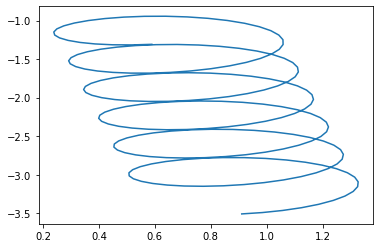

In [33]:
from matplotlib import pyplot as plt
plt.plot(p_array[:,0], p_array[:,2])


In [47]:
p49, p50, p51 = p_array[49:52]
a49, a50, a51 = a_array[49:52]

uv_ = quaternion.rotate_vectors(q0.inverse(), p50 - x0)
p_dirc = quaternion.rotate_vectors(q0.inverse(), p51 - p49)
a_dirc = quaternion.rotate_vectors(q0.inverse(), a51 - a49)


In [48]:
from numpy.linalg import norm

cos_alp_ = np.dot(p_dirc, a_dirc) / norm(p_dirc) / norm(a_dirc)
cos_alp_


0.19624468426306935

In [50]:
alps     = da + 2 * np.pi * l0 / L0 * s_array[50]
y50, z50 = r0 * np.cos(alps), r0 * np.sin(alps)

y50, z50

(-0.2933941488411433, -0.2718820947134641)

In [51]:
uv_

array([ 0.75375968, -0.29340619, -0.2718715 ])

In [53]:
dpds = p_dirc / (s_array[51] - s_array[49])
dpds

array([  3.00053339,  10.18842733, -10.994585  ])

In [54]:
dpxds = np.dot(dpds, a_dirc) / norm(a_dirc)
dpxds

2.9999654165372642

In [57]:
dphids = norm(dpds - dpxds * a_dirc / norm(a_dirc))
dphids


14.989608362480201